# CLASSIFICAÇÃO 

# MNIST

In [1]:
# A Scikit-Learn fornece muitas funções auxiliares para fazer o download de conjuntos de dados populares. O MNIST é um deles. O código 
# a seguir obtém o conjunto de dados do MNIST:

# ATENÇÃO: desde o Scikit-Learn 0.24, fetch_openml() retorna um Pandas DataFrame por padrão. 
#Para evitar isso e manter o mesmo código do livro, usamos as_frame=False.

from sklearn.datasets import fetch_openml
mnsit = fetch_openml('mnist_784', version = 1, as_frame=False)
mnsit.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# uma chave DESCR que descreve o conjunto de dados.
# Uma chave DATA que contém um array com uma linha por instância e uma coluna por característica.
# Uma chave target que contém um array com os rótulos.

X, y = mnsit['data'], mnsit['target']
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


Existem 70 mil imagens e cada uma delas apresenta 784 características. Isso ocorre porque cada imagem tem 28x28 pixels, e cada característica representa simplesmente a intensidade de um pixel, de 0(branco) a 255(preto). Vamos dar uma espiada em um algarismo do conjunto de dados. Tudo que precisamos fazer é pegar o vetor de caractrística de uma instância, remodelá-lo em um array de 28x28 e exibi-lo usando a função imshow() da Matplotlib:

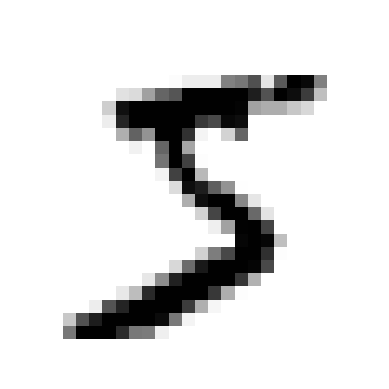

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [4]:
# o algarismo parece com um 5, e é justamente isso que o rótulo informa: 
print('rótulo = ', y[0])

#Repare que o rótulo é uma string. a maioria dos algoritmos que aprendizado de maquina espera números, logo convertemos y para inteiro:
import numpy as np
y = y.astype(np.uint8)

rótulo =  5


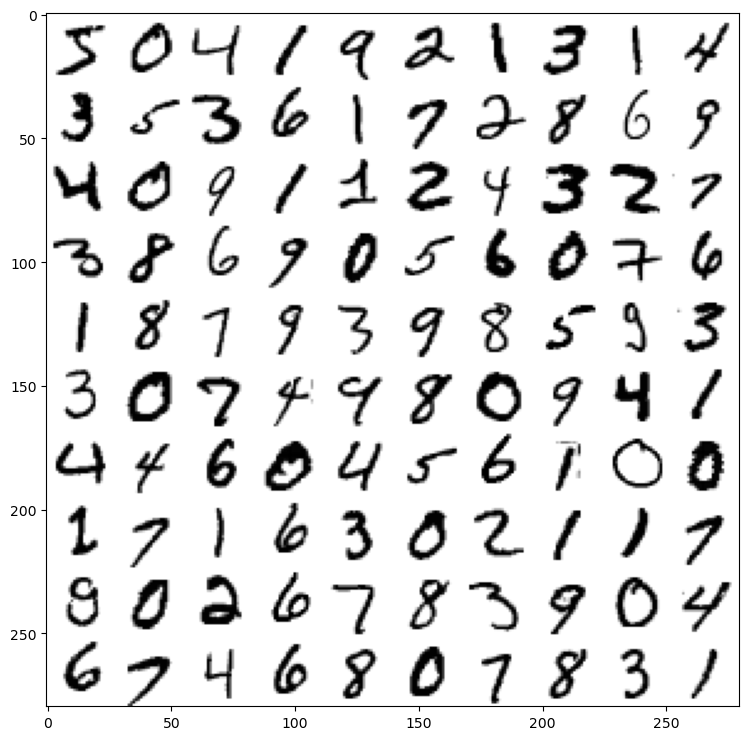

In [5]:
# EXTRA PARA GERAR ALGUMAS IMAGENS DO CONJUNTO DE DADOS MNIST.

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # Isso é equivalente a n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Anexe imagens vazias para preencher o final da grade, se necessário:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reformule a matriz para que fique organizada como uma grade contendo imagens 28×28:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine os eixos 0 e 2 (eixo de grade de imagem vertical e eixo de imagem vertical),
    # e eixos 1 e 3 (eixos horizontais). Primeiro precisamos mover os eixos que
    # queremos combinar um ao lado do outro, usando transpose(), e só então
    # pode remodelar:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    # Agora que temos uma imagem grande, só precisamos mostrá-la:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [6]:
# SEPARANDO EM TREINO E TESTE !
# treino (as 60 mil primeiras imagens ) e treino (as 10 mil ultimas imagens)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# obs: base já embaralhada!

Treinando um classificador Binário

In [7]:
# para simplificar nesse exemplo tentamos identificar apenas uma observação, o número '5'. Que será uma exemplo de classificador 
# binário capas de fazer distribuições em apenas duas classes 5 e não-5

y_train_5 = (y_train == 5) #True para todos os 5s, False para todos as outras obserações. 
y_test_5 = (y_test == 5)

In [8]:
# escolhendo um classificar e treinando !
# usando o gradiente classificador estocástico(SGD) pois ele consegui lidar eficientemente com conjunto de dados muito grandes.
#SGD lida com instâncias de treinamento de forma independentes, uma de cada vez. 

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier( random_state=42)
sgd_clf.fit(X_train, y_train_5)

# -> o SGDClassifier depende da aleatoriedade durante o treinamento(por isso, o nome "estocástico"). Para resultados que possam ser 
# reproduzidos, deina o parâmetro random_state.

SGDClassifier(random_state=42)

In [9]:
# agora, podemos usá-lo para detectar imagens de número 5: 
sgd_clf.predict([some_digit])

array([ True])

# Cálculo de Desempenho

In [10]:
#VALIDAÇÃO CRUZADA 

#avaliando o modelo com o método k-fold de validação cruzada em três partes
# -> isso significa dividir o conjunto de treinamento em k-fold (nesse caso 3), depois prever e avaliar as predição de cada um. 

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Medindo a precisão usando a validação cruzada

In [11]:
# VALIDAÇÃO CRUZADA SEM USAR 'cross_val_score'  - SEGUNDA FORMA DE FAZER

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Observação: **shuffle=True** foi omitido por engano em versões anteriores do livro.

### MATRIZ DE CONFUSÃO

In [12]:
# MATRIZ DE CONFUSÃO

# realizando as predições 
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# realizando a matriz de confusão
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

 ou seja, 687 foiclassificado errado as imagem com 5  e  1891 observações foi classificado errado as imagem com não-5 !

 -> Um classificador perfeito teria somente verdadeiros positivos e verdadeiros negativos, ou seja, sua matriz de confusão teria valores diferentes de zero apenas em sua diagonal principal (da esquerda superior para a direita inferior)

### Precisão e revocação 

In [13]:
#A scikit-learn fornece diversar funções para calcular métrcias classificadoras, incluindo precisão e revocação:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
print("primeiro resultado, precision_score = ",precision_score(y_train_5, y_train_pred) )

#precisão apartir da matriz e confusão
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])
print("segundo resultado, precisão apartir da matriz e confusão = ", cm[1, 1] / (cm[0, 1] + cm[1, 1]))

#revocação
recall_score(y_train_5, y_train_pred)
print("terceiro resultado, revocação:", recall_score(y_train_5, y_train_pred))

primeiro resultado, precision_score =  0.8370879772350012
segundo resultado, precisão apartir da matriz e confusão =  0.8370879772350012
terceiro resultado, revocação: 0.6511713705958311


In [14]:
#É importante notar que alta revocação não garante alta precisão, e vice-versa. 
# Uma forma de balancear esses dois indicadores é o f1-score, que leva em conta tanto precisão quanto revocação.

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Ao aumentar a precisão reduz a revocação e vice-versa. isso se chama trade-off precisão/revocação. 

### Trade-off de precisão/revocação

Em vez de chamar o método *predict()* do classificador , é possível utilizar o método *decision_function()*, que retorna um score para cada instância e, em seguida, faz as predições com base nesses scores usando qualquer limiar desejado: 

In [15]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [17]:
# o SGDClassifier utiliza um limiar igual a 0,assim o código anterior retorna o mesmo resultado que o método preditct() (ou seja,True).
# Vamos aumentar esse limiar:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Isso comprova que aumentar o limiar diminui a revocação!

In [18]:
# usando a fução cross_val_predict() para obter os scores de todas as instâncias no conunto de treinamento, 
# especificando o retorno dos scores de decisão,em vez de predições:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [19]:
# com os scores, use a fução precision_recal_curve() para calcular a precisão e a revocação de todos os limiares possíveis: 
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

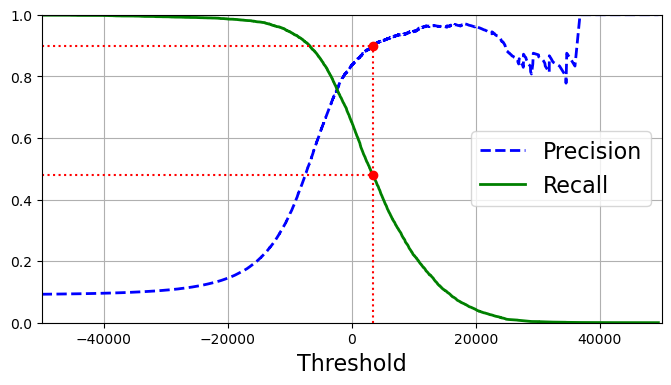

Precisão [Precision] e Revocação [Recall] vs. limiar de decisão [threshold]


In [20]:
# plotando a precisão e a revocação 

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    # apartir daqui destaca o limiar e acrescnta legenda, rótulo de eixo e a grade
    plt.legend(loc="center right", fontsize=16)  
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                               
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # para salvar o gráfico
plt.show()

#informaçõs do gráfico
print("Precisão [Precision] e Revocação [Recall] vs. limiar de decisão [threshold]")

a curva de precisão mais irregular que a precisão ?

-  motivo é que, as vezes, a precisão pode diminuir quando aumentamos o limiar(embora geralmente aumente)

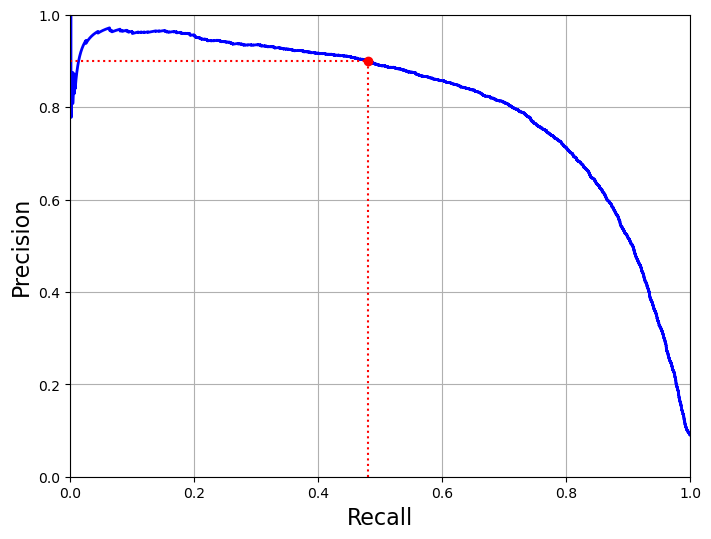

In [21]:
#outra maneira de escolher um bom trade-off de precisão/revocação é plotar diretamente em relação á revocação.

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

In [22]:
# supondo que queremos uma precisão de 90% com o limiar mais baixo possível, podemos fazer dessa forma:
# np.argmax lhe dará o primeiro índice do valor máximo, que neste caso significa o primeiro valor TRUE)

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [23]:
# é possível fazer predições sem usar o mérodo predict() do classificador, utilize: 
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [24]:
# conferindo a precisão e a revocação dessas predições:
precision_score(y_train_5, y_train_pred_90) 
print('precision_score:', precision_score(y_train_5, y_train_pred_90))

recall_score(y_train_5, y_train_pred_90)
print('recall_score:', recall_score(y_train_5, y_train_pred_90))

precision_score: 0.9000345901072293
recall_score: 0.4799852425751706


conseguimos um classificador com 90% de precisão, mas classificador de alta precisão não é lá muito útil, se sua revocação for muito baixa! 

### A Curva ROC 

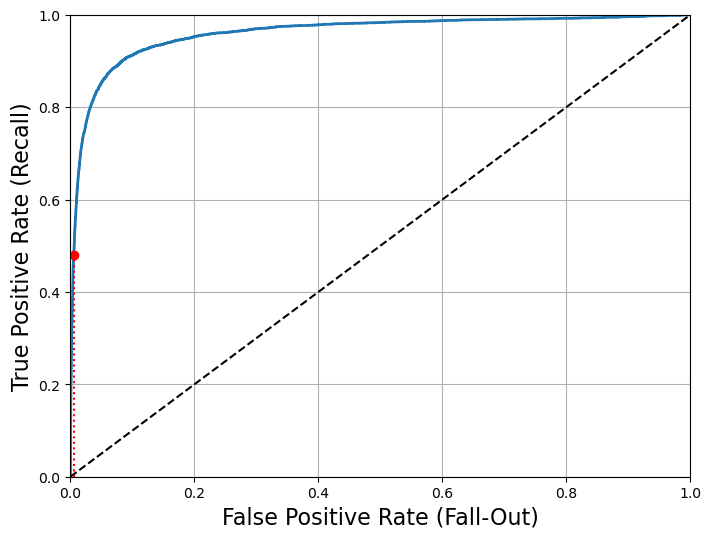

In [25]:
# calculando a curva ROC -------------------
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Plotando a curva ROC --------------------
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # diagonal tracejada
    #adicionando rpotulos aos eixos e grade
    plt.axis([0, 1, 0, 1])                                    # Não mostrado no livro
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # eixo x com fonte de tamanho 16
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # eixo y com fonte de tamanho 16
    plt.grid(True)                                            # ativa a grade no gráfico corrente.

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
# save_fig("roc_curve_plot")                                  # salva o gráfico como imagem 
plt.show()

Esta curva ROC representa a taxa de falsos positivos [*false positive rate*] em relação aá taxa de verdadeiros posítivos [*true positive rate*] para todos os limiares possíveis: o ponto no gráfico destaca a proporção escolhida (com 46,68 % de revocação)

In [27]:
# uma forma de comparar os classificadores é calcular a área sob a curva (AUC). Um classificador perfeito terá uma ROC AUC igual a 1, enquanto um classificador exclusivo aleátorio
# terá um ROC AUC igual a 0,5. Assim, a Scikit-Learn tem uma função para calcular o ROC AUC: 

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Observação:** definimos n_estimators=100 para ser à prova de futuro, pois esse será o valor padrão no Scikit-Learn 0.22.

In [28]:
#   treinando os dados com o modelo floresta aleatoria e comparando a curva ROC e scores ROC AUC com as do SGDClassifier
# obs:
# RandomForestClassifier não tem um método decision_function(), invez disso tem predict_proba().

# -> predict_proba() informa um array que contém um linha por instância e uma coluna por classe, cada uma com a probabilidade de que a instância especificada
# exemplo : (70% de probabilidade de que a imagem represente um 5)

from sklearn.ensemble import RandomForestClassifier # import da biblioteca 
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42) # modelo floresta aleatoria 
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") 

In [29]:
# roc_curve() recebe rótulos e scores, mas vamos fornecer probabilidades das classes com scores
y_scores_forest = y_probas_forest[:, 1] # score = prbabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

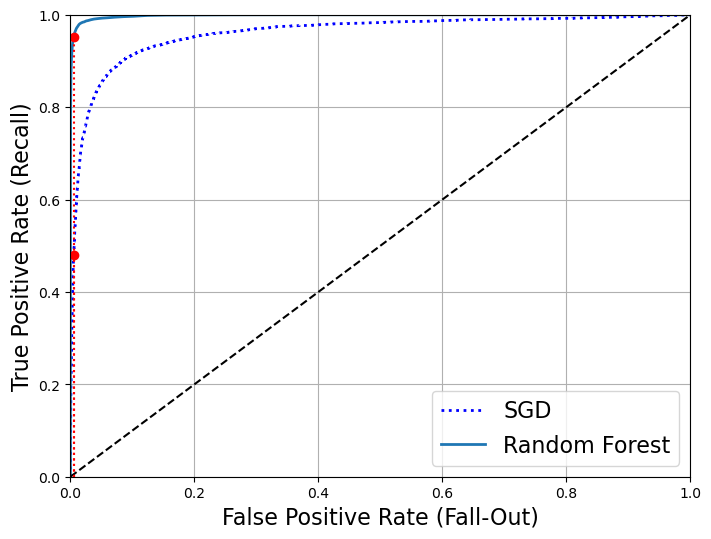

In [30]:
# Plotado a curva ROC.

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
plt.show()

a curva ROC do *RandomForestClassifier* parece bem melhor que a do *SGDClassifier* (fica mais perto do canto superior esquerdo), como resultado, seu score no ROC AUC também é substancialmente melhor

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [32]:
# encontrando o score de precisão:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [33]:
# encontrando o score de revocação:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Classificação Multiclasse

In [34]:
#utilizando um classificador de máquina de vetores de suporte
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
# decision_function() retorna 10 scores por instâncias(em vez de apenas 1), é um score por classe
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [36]:
# o score mais alto é de fato o que corresponde á classe 5
np.argmax(some_digit_scores)

5

In [37]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [38]:
svm_clf.classes_[5]

5

In [39]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
len(ovr_clf.estimators_)

10

In [41]:
# treinando um SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [42]:
# score que o SGDClassifier um valor por classe 
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Aviso: as duas células a seguir podem levar cerca de 30 minutos para serem executadas ou mais, dependendo do seu hardware.

In [43]:
# avaliando o classificador usando validação cruzada, para avaliar a acurácia do SGDClassifier.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

o resultado foi bom, mas é possível aumentar a acurácia fazendo:

In [44]:
# usando um classificador aleatório  e fazendo um escalonamento das entradas para aumentar a acurácia acima de 89%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Análise de Erro